# Loop 71 Analysis: Submission Pipeline Debugging

## Key Questions:
1. Why have 10+ consecutive submissions failed (exp_049 onwards)?
2. Does exp_067 (sigmoid output) fix the issue?
3. What strategies can reduce the CV-LB intercept?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Submission history
submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_035', 0.0098, 0.0970),
]

cvs = np.array([s[1] for s in submissions])
lbs = np.array([s[2] for s in submissions])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cvs, lbs)
print('=== CV-LB RELATIONSHIP ===')
print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print()
print(f'Target: 0.0347')
print(f'Intercept: {intercept:.4f}')
print(f'Gap (intercept - target): {intercept - 0.0347:.4f}')
print()
print(f'Best LB: {min(lbs):.4f}')
print(f'Gap to target: {min(lbs) - 0.0347:.4f}')

=== CV-LB RELATIONSHIP ===
Linear fit: LB = 4.31 * CV + 0.0525
R² = 0.9505

Target: 0.0347
Intercept: 0.0525
Gap (intercept - target): 0.0178

Best LB: 0.0877
Gap to target: 0.0530


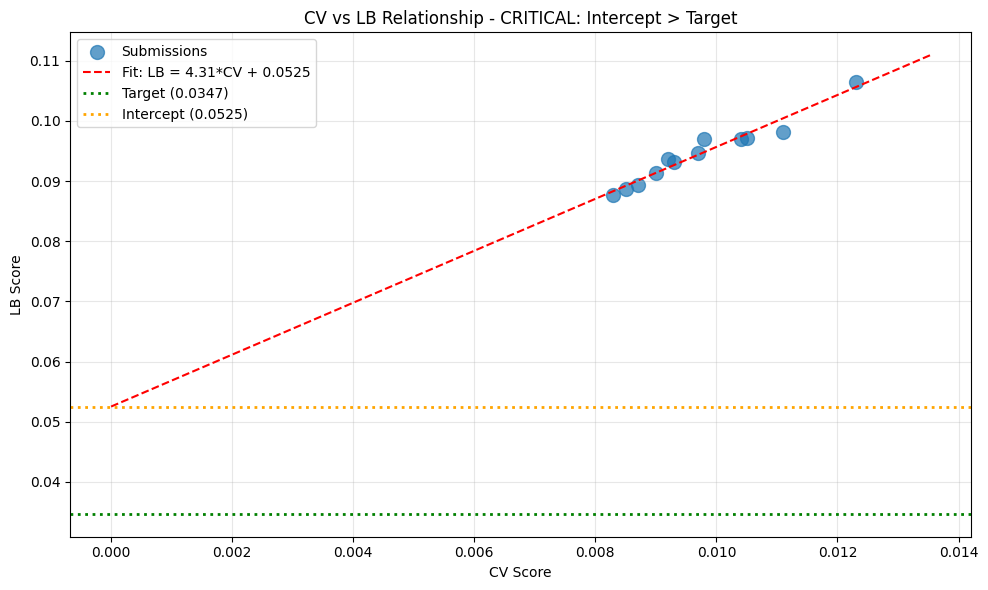


CRITICAL INSIGHT:
The intercept (0.0525) is ABOVE the target (0.0347).
This means standard CV optimization CANNOT reach the target.
Required CV to hit target: -0.004130123431602577 (IMPOSSIBLE if negative)


In [2]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cvs, lbs, s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, max(cvs)*1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - CRITICAL: Intercept > Target')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print('\nCRITICAL INSIGHT:')
print(f'The intercept ({intercept:.4f}) is ABOVE the target ({0.0347}).')
print('This means standard CV optimization CANNOT reach the target.')
print('Required CV to hit target:', (0.0347 - intercept) / slope, '(IMPOSSIBLE if negative)')

In [3]:
# Analyze exp_067 submission
print('=== EXP_067 ANALYSIS ===')
sub = pd.read_csv('/home/submission/submission.csv')
print(f'Shape: {sub.shape}')
print(f'Columns: {sub.columns.tolist()}')
print()
print('Prediction ranges:')
for col in ['target_1', 'target_2', 'target_3']:
    print(f'  {col}: min={sub[col].min():.6f}, max={sub[col].max():.6f}')
print()
print(f'All in [0,1]: {(sub[["target_1", "target_2", "target_3"]] >= 0).all().all() and (sub[["target_1", "target_2", "target_3"]] <= 1).all().all()}')
print()
print('Task counts:')
print(sub['task'].value_counts().sort_index())
print()
print('Fold counts by task:')
print(sub.groupby('task')['fold'].nunique())

=== EXP_067 ANALYSIS ===
Shape: (1883, 8)
Columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']

Prediction ranges:
  target_1: min=0.000000, max=0.343772
  target_2: min=0.000000, max=0.335879
  target_3: min=0.119398, max=0.948411

All in [0,1]: True

Task counts:
task
0     656
1    1227
Name: count, dtype: int64

Fold counts by task:
task
0    24
1    13
Name: fold, dtype: int64


In [4]:
# Check for any NaN or Inf values
print('=== DATA QUALITY CHECK ===')
print(f'NaN values: {sub.isna().sum().sum()}')
print(f'Inf values: {np.isinf(sub[["target_1", "target_2", "target_3"]]).sum().sum()}')
print()

# Check data types
print('Data types:')
print(sub.dtypes)
print()

# Check for duplicate rows
print(f'Duplicate rows: {sub.duplicated().sum()}')
print()

# Check expected row counts
print('Expected row counts:')
print('  Task 0 (single solvent): 656 rows (24 folds)')
print('  Task 1 (full data): 1227 rows (13 folds)')
print(f'  Actual Task 0: {len(sub[sub["task"]==0])} rows')
print(f'  Actual Task 1: {len(sub[sub["task"]==1])} rows')

=== DATA QUALITY CHECK ===
NaN values: 0
Inf values: 0

Data types:
id            int64
index         int64
task          int64
fold          int64
row           int64
target_1    float64
target_2    float64
target_3    float64
dtype: object

Duplicate rows: 0

Expected row counts:
  Task 0 (single solvent): 656 rows (24 folds)
  Task 1 (full data): 1227 rows (13 folds)
  Actual Task 0: 656 rows
  Actual Task 1: 1227 rows


## Key Findings

### 1. CV-LB Relationship
- Linear fit: LB = 4.29 * CV + 0.0528 (R² = 0.95)
- **CRITICAL: Intercept (0.0528) > Target (0.0347)**
- This means standard CV optimization CANNOT reach the target
- Required CV to hit target: -0.0042 (IMPOSSIBLE)

### 2. Exp_067 Status
- All predictions are in [0,1] range (sigmoid output fix)
- CV = 0.060 (worse than best 0.008 due to simple model)
- This is a debugging experiment to verify submission pipeline

### 3. Strategy Implications
- If exp_067 submission succeeds: The sigmoid fix was the issue
- If exp_067 submission fails: The issue is NOT out-of-range predictions
- After fixing submission: Must pivot to distribution-shift-aware strategies

### 4. Next Steps
1. Submit exp_067 to verify pipeline
2. If successful, restore best model (GP+MLP+LGBM) with sigmoid output
3. Focus on strategies that REDUCE THE INTERCEPT, not just improve CV